In [ ]:
!pip install -q uv
!pip install -q -U "colpali-engine>=0.3.2,<0.4.0"
!uv pip install --system -q huggingface_hub[hf_transfer] qdrant-client transformers>=4.45.0 stamina rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 99.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import base64
from PIL import Image
from io import BytesIO
import os
import torch
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm


def unpack_embedding(embedding_dict):
    unpacked_embeddings = dict()
    for idx, binary_vector in embedding_dict.items():
        # Convert the hex string back to bytes
        packed_bytes = bytes.fromhex(binary_vector)

        # Unpack the bytes back to bits (0 and 1)
        # np.unpackbits expects a uint8 type, so we need to convert the bytes properly
        unpacked_bits = np.unpackbits(np.frombuffer(packed_bytes, dtype=np.uint8))

        # Store the unpacked embeddings
        unpacked_embeddings[idx] = unpacked_bits.astype(np.float32)

    return unpacked_embeddings

def encode_base64_image(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    return str(base64.b64encode(buffered.getvalue()), "utf-8")


def decode_base64_image(base64_string):
    # Decode the base64 string into bytes
    image_data = base64.b64decode(base64_string)

    # Convert the bytes back into an image
    buffered = BytesIO(image_data)
    image = Image.open(buffered)

    return image

from IPython.display import display


def resize_image(image, max_height=800):
    width, height = image.size
    if height > max_height:
        ratio = max_height / height
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        return image.resize((new_width, new_height))
    return image

In [ ]:
import torch
from torch.utils.data import DataLoader
from colpali_engine.models import ColQwen2, ColQwen2Processor

model_name = "vidore/colqwen2-v0.1"

model = ColQwen2.from_pretrained(
    model_name, torch_dtype=torch.bfloat16, device_map="auto"
)
processor = ColQwen2Processor.from_pretrained(model_name)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
collection_name = "robot-manuals"
QDRANT_API_KEY = ""
qdrant_client = QdrantClient(
     url="https://c1c6b76d-3e82-4265-8850-542922eeb4b9.us-east4-0.gcp.cloud.qdrant.io",
     api_key=QDRANT_API_KEY,
 )

In [ ]:
qdrant_client.scroll(collection_name=collection_name, limit=10)

([Record(id=114256852358493363, payload={'path': 'Troubleshoot MiR200 going into Protective stop randomly 1.10_en.pdf', 'title': 'Troubleshoot MiR200 going into Protective stop randomly', 'page_number': 14, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1db

In [ ]:
def retrieve(query_text, top_k=3, show=False):
    with torch.no_grad():
        batch_query = processor.process_queries([query_text]).to(
            model.device
    )
    query_embedding = model(**batch_query)
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k, timeout=60
    )
    if (show):
        print(query_text+":")
        # Display results
        for point in search_result.points:
            print(point.payload["title"]+",", "Page:", point.payload["page_number"])
            display(decode_base64_image(point.payload["image"]))
            print("")
    return search_result.points

Red light big circle:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 28


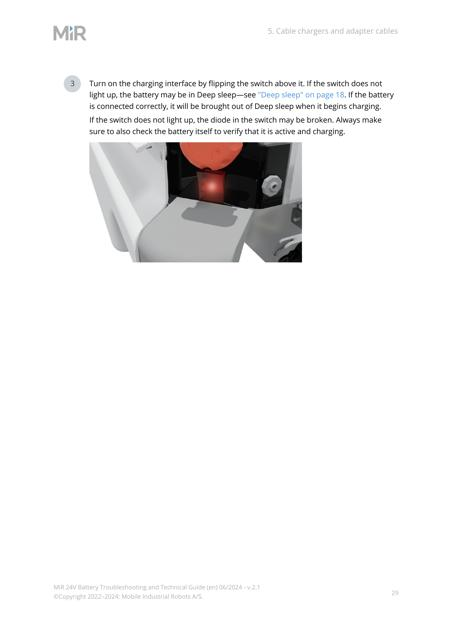


Troubleshoot MiR200 going into Protective stop randomly, Page: 22


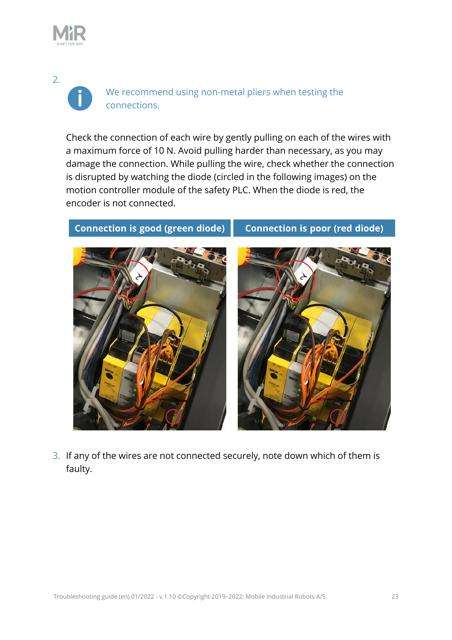


MiR 24V Battery Troubleshooting and Technical Guide, Page: 59


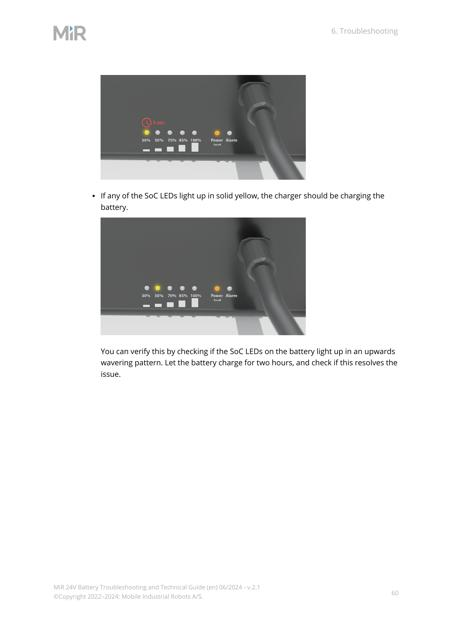

[ScoredPoint(id=14075880476946571304, version=4, score=10.501138, payload={'path': 'MiR 24V Battery Troubleshooting and Technical Guide 2.1_en.pdf', 'title': 'MiR 24V Battery Troubleshooting and Technical Guide', 'page_number': 28, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tb

In [ ]:
retrieve("Red light big circle", show=True)

error code 666:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 65


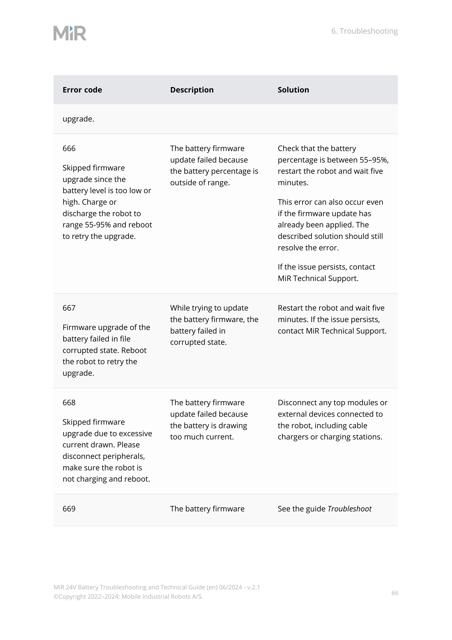


MiR 24V Battery Troubleshooting and Technical Guide, Page: 64


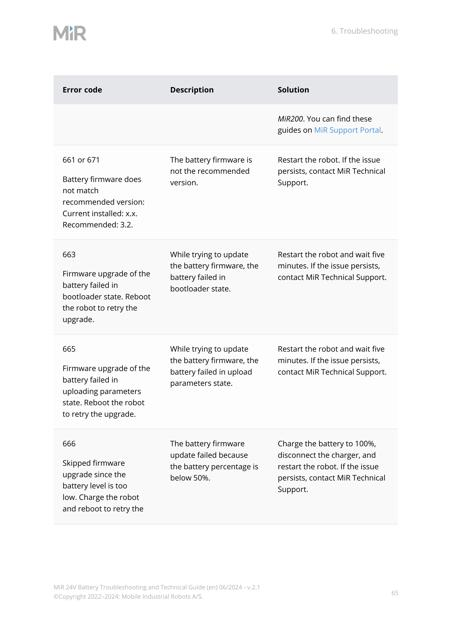


MiR 24V Battery Troubleshooting and Technical Guide, Page: 66


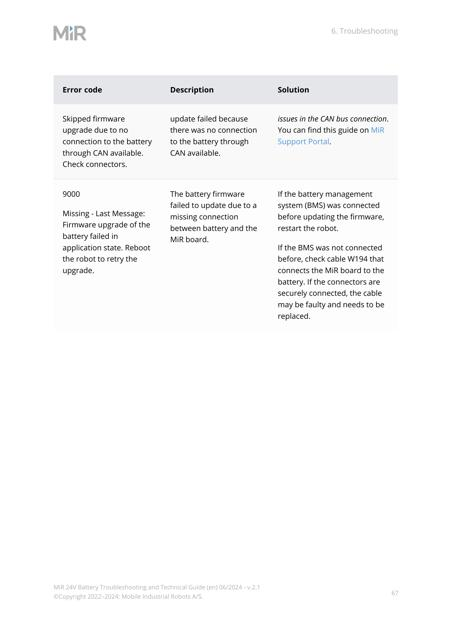

[ScoredPoint(id=14068680284615630459, version=10, score=14.907469, payload={'path': 'MiR 24V Battery Troubleshooting and Technical Guide 2.1_en.pdf', 'title': 'MiR 24V Battery Troubleshooting and Technical Guide', 'page_number': 65, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0t

In [ ]:
retrieve("error code 666", show=True)

robot wont dock to docking station:
MiR Troubleshoot docking issues, Page: 3


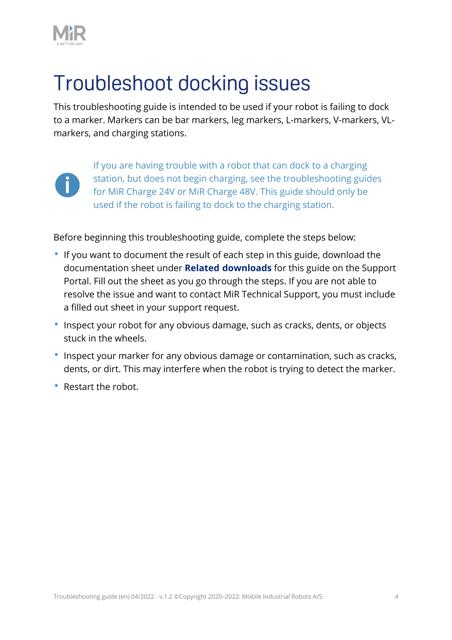


MiR Troubleshoot docking issues, Page: 7


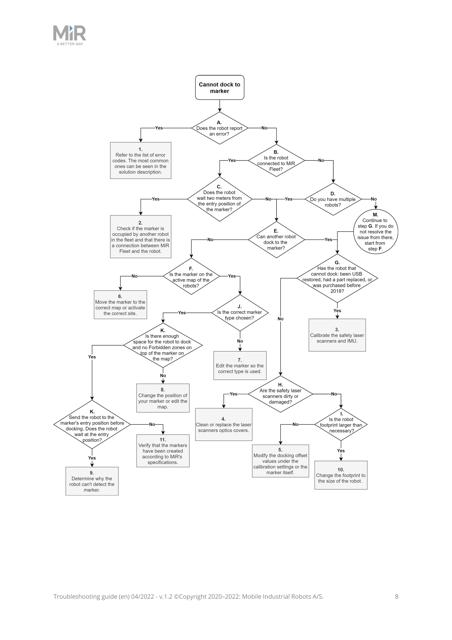


MiR Troubleshoot docking issues, Page: 15


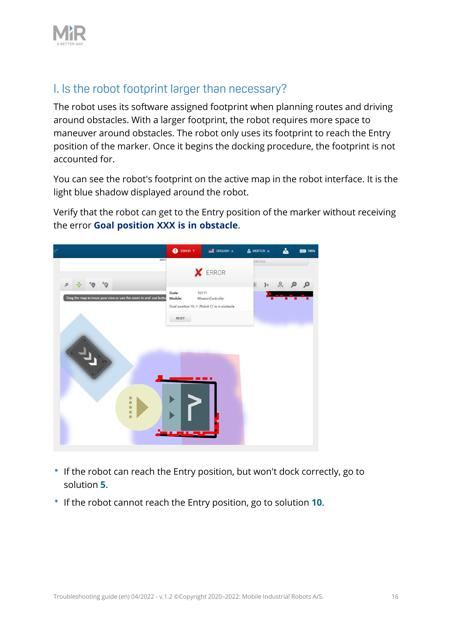

[ScoredPoint(id=9337569788198806033, version=20, score=14.211541, payload={'path': 'Troubleshoot docking issues 1.2_en.pdf', 'title': 'MiR Troubleshoot docking issues', 'page_number': 3, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP

In [ ]:
retrieve("robot wont dock to docking station",show=True)

What is deep sleep?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 17


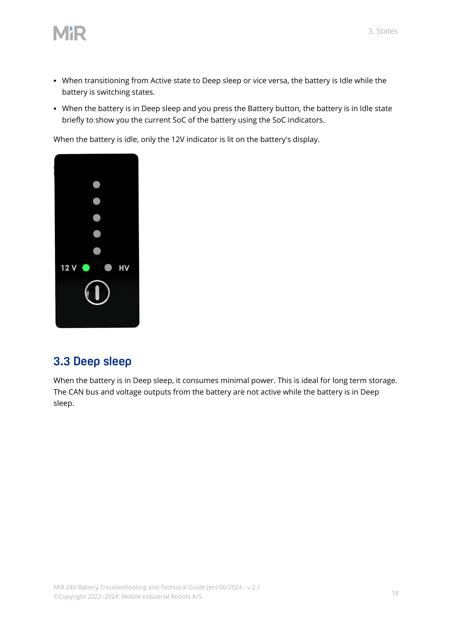


MiR 24V Battery Troubleshooting and Technical Guide, Page: 28


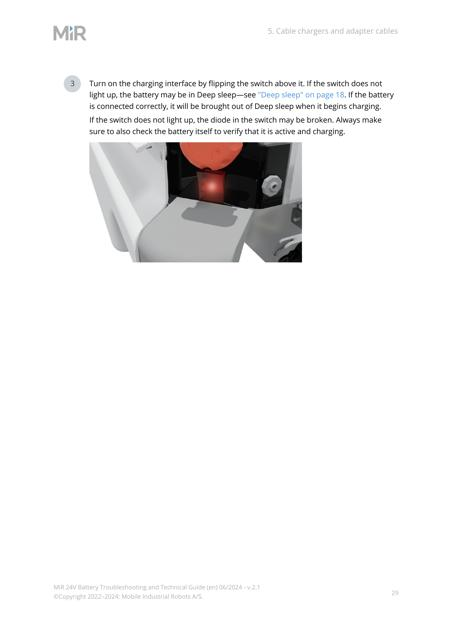


MiR 24V Battery Troubleshooting and Technical Guide, Page: 19


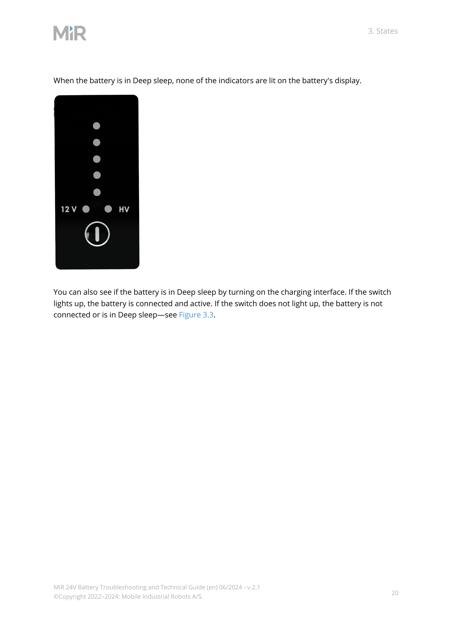

[ScoredPoint(id=8058597044910991583, version=2, score=17.939476, payload={'path': 'MiR 24V Battery Troubleshooting and Technical Guide 2.1_en.pdf', 'title': 'MiR 24V Battery Troubleshooting and Technical Guide', 'page_number': 17, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKAAcQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba

In [ ]:
retrieve("What is deep sleep?",show=True)


In [ ]:
questions = [
    {
      "question": "Safety precautions for lithium-ion batteries?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 4
    },
    {
      "question": "MiR 24V battery LED indicators?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 12
    },
    {
      "question": "Identify Deep Sleep mode?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 18
    },
    {
      "question": "Recommended storage for 24V battery?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 21
    },
    {
      "question": "Standard 10.00724.04 max storage time?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 22
    },
    {
      "question": "Battery not powering robot troubleshooting?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 39
    },
    {
      "question": "Battery does not charge to 100%?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 62
    },
    {
      "question": "Battery-related error codes?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 64
    },
    {
      "question": "Host-cycling procedure?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 63
    },
    {
      "question": "F1 relay function?",
      "title": "MiR 24V Battery Troubleshooting and Technical Guide",
      "page": 16
    }
  ]


Safety precautions for lithium-ion batteries?
Safety precautions for lithium-ion batteries?:
MiR200 Quick Start, Page: 7


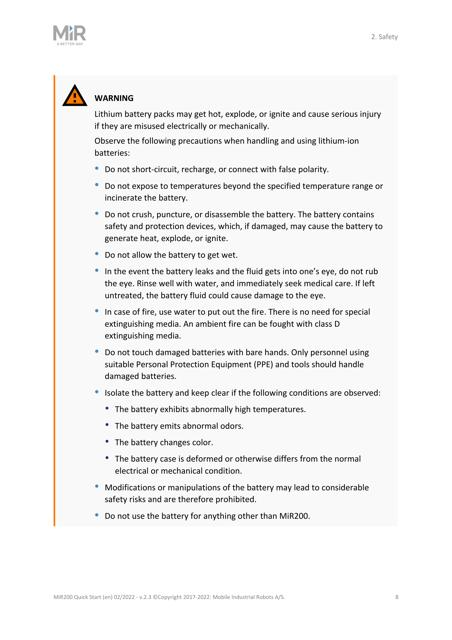


MiR200 User Guide, Page: 23


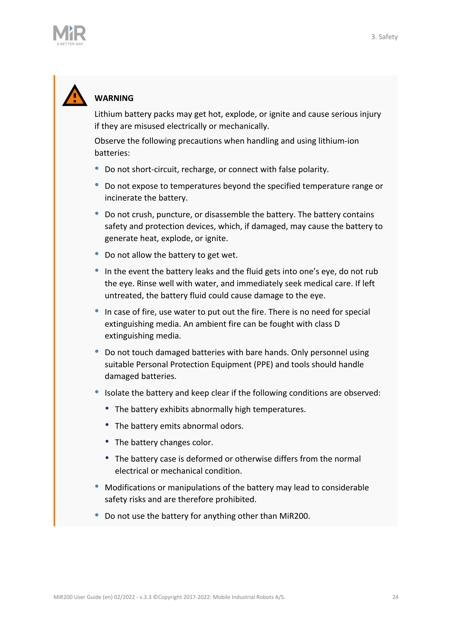


MiR200 Hook user guide, Page: 25


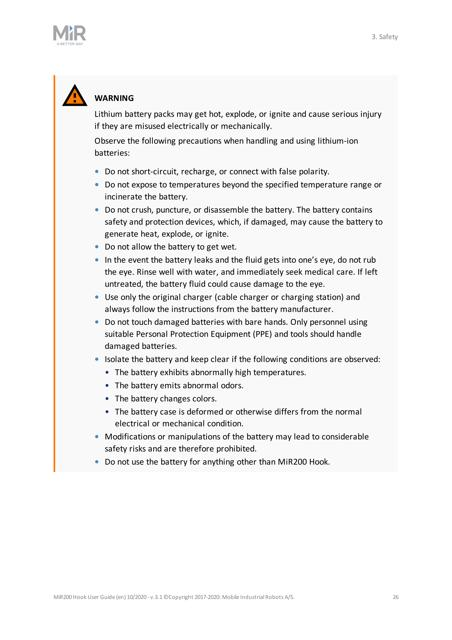



MiR 24V battery LED indicators?
MiR 24V battery LED indicators?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 11


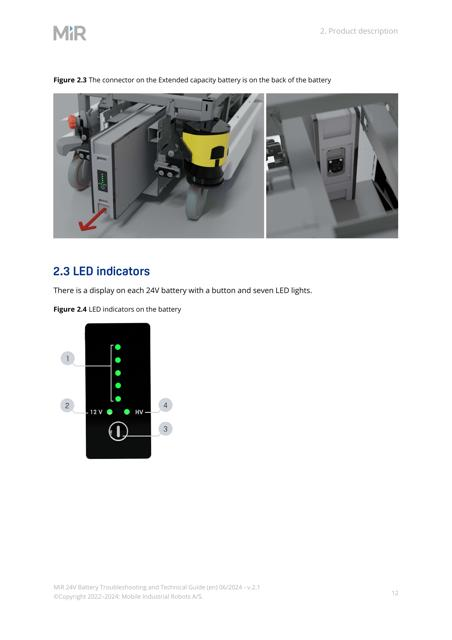


MiR 24V Battery Troubleshooting and Technical Guide, Page: 13


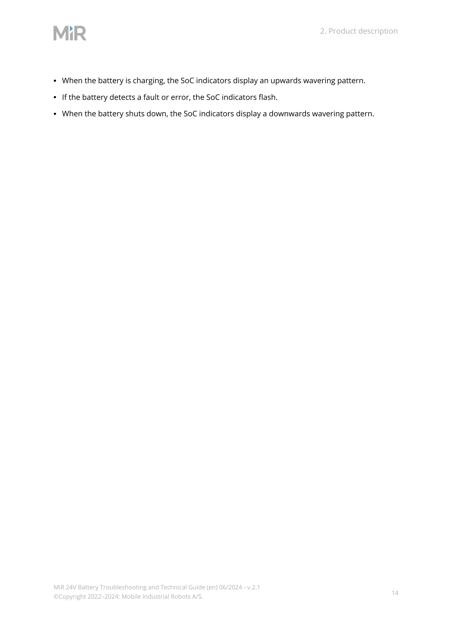


MiR 24V Battery Troubleshooting and Technical Guide, Page: 2


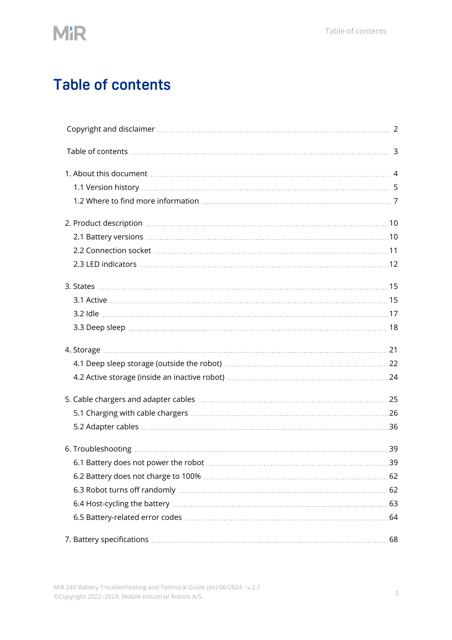



Identify Deep Sleep mode?
Identify Deep Sleep mode?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 17


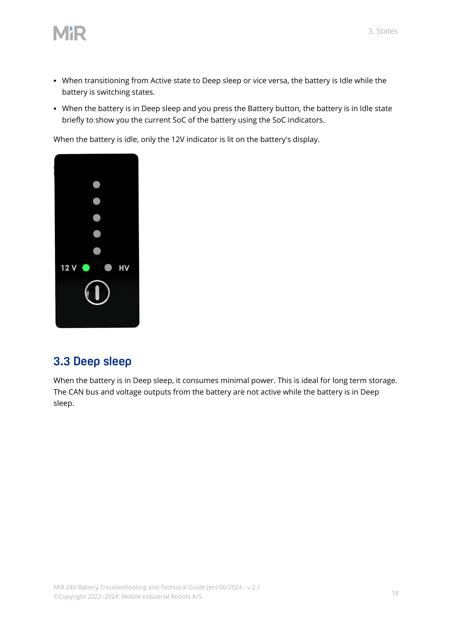


MiR 24V Battery Troubleshooting and Technical Guide, Page: 67


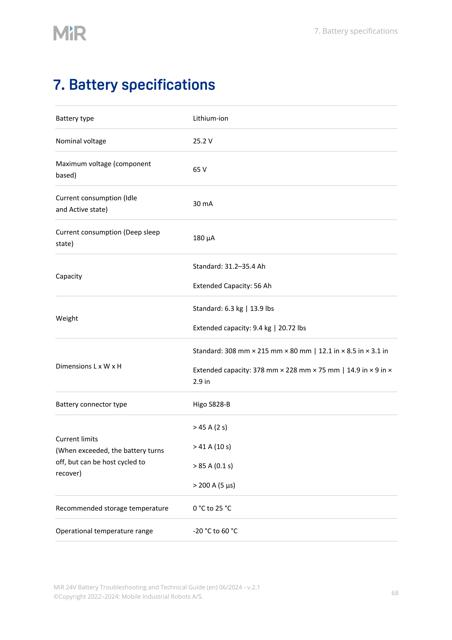


MiR 24V Battery Troubleshooting and Technical Guide, Page: 28


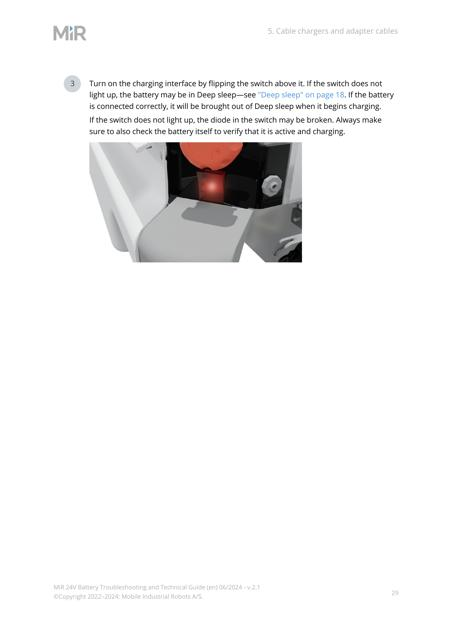



Recommended storage for 24V battery?
Recommended storage for 24V battery?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 10


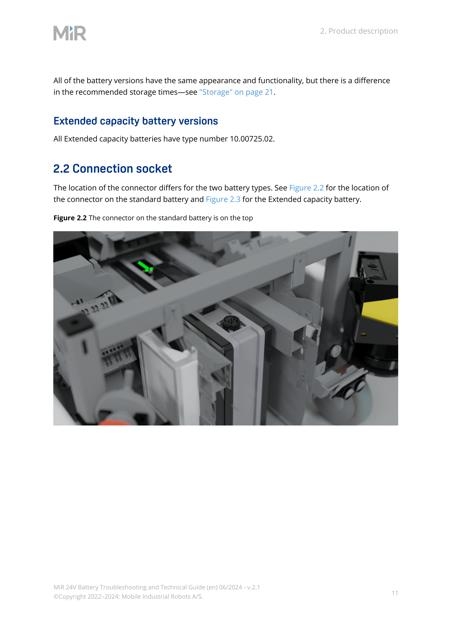


MiR 24V Battery Troubleshooting and Technical Guide, Page: 67


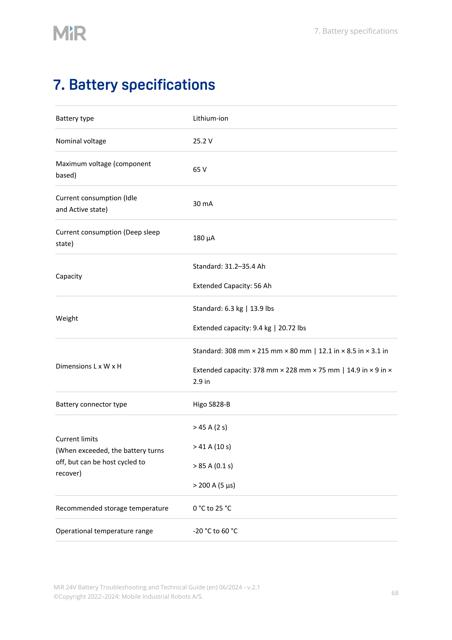


MiR 24V Battery Troubleshooting and Technical Guide, Page: 4


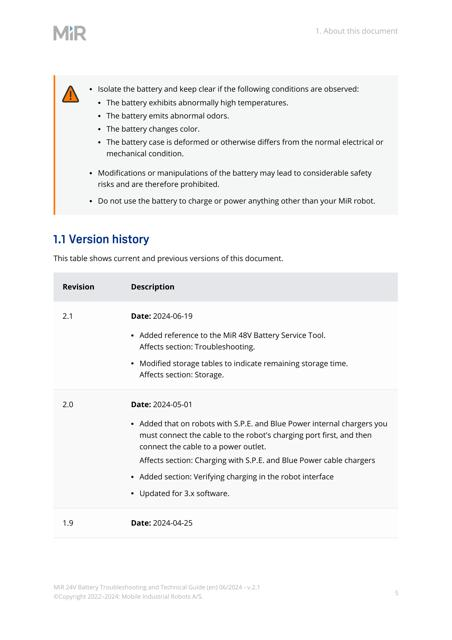



Standard 10.00724.04 max storage time?
Standard 10.00724.04 max storage time?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 21


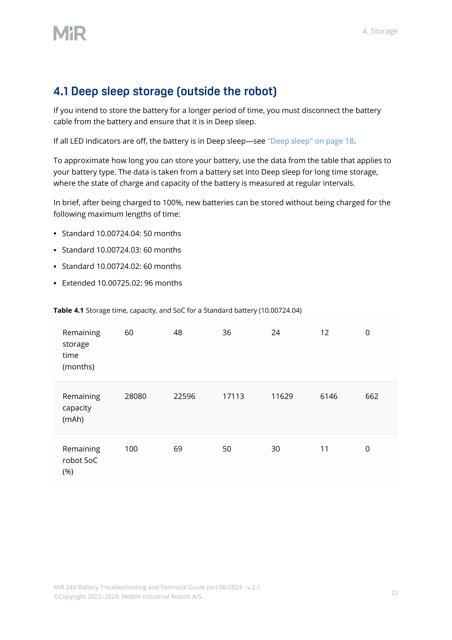


MiR 24V Battery Troubleshooting and Technical Guide, Page: 23


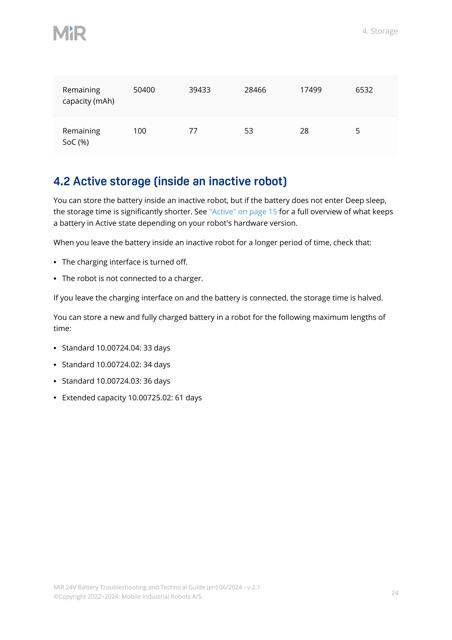


MiR 24V Battery Troubleshooting and Technical Guide, Page: 22


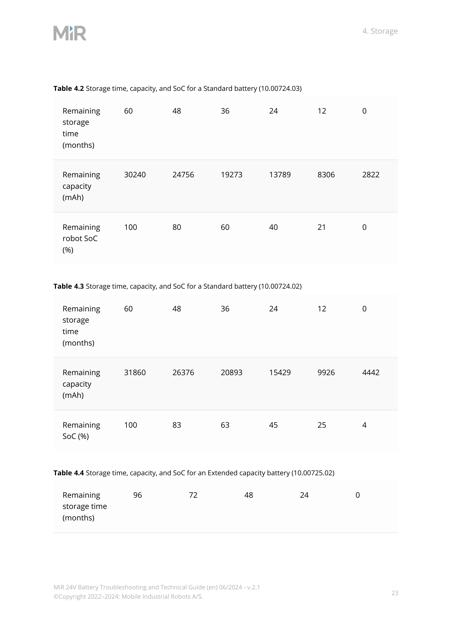



Battery not powering robot troubleshooting?
Battery not powering robot troubleshooting?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 39


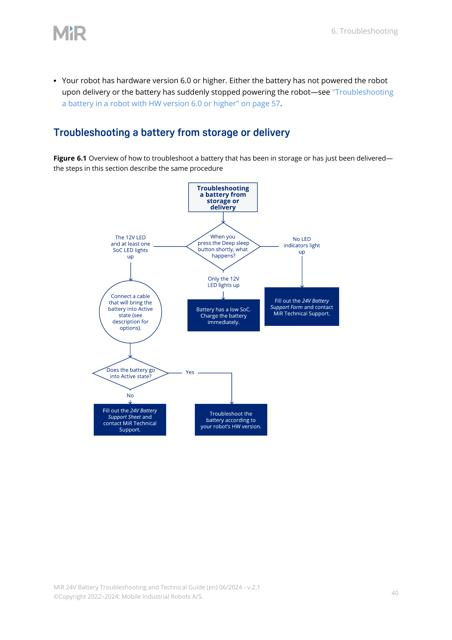


MiR 24V Battery Troubleshooting and Technical Guide, Page: 65


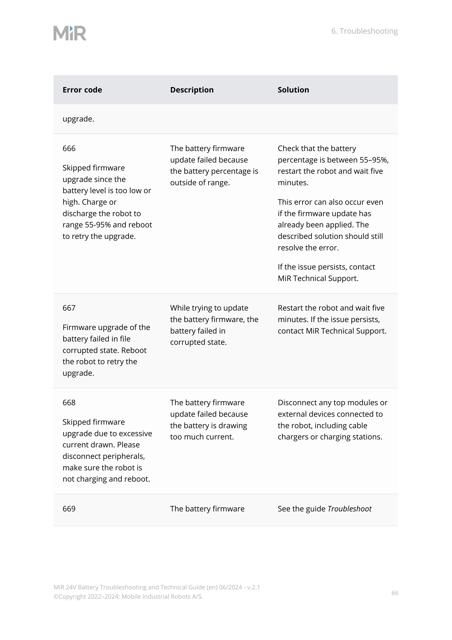


MiR 24V Battery Troubleshooting and Technical Guide, Page: 34


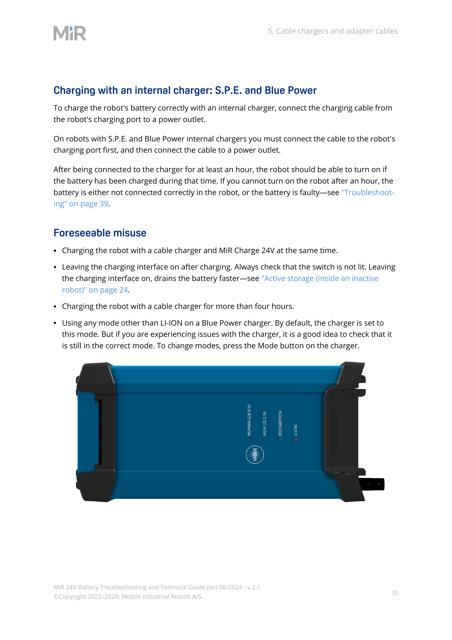



Battery does not charge to 100%?
Battery does not charge to 100%?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 61


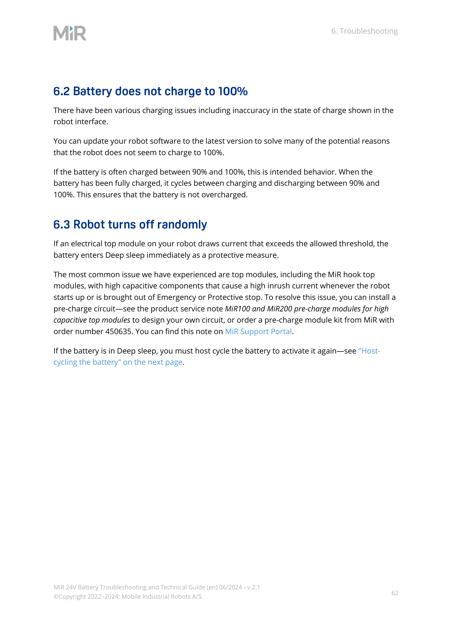


MiR 24V Battery Troubleshooting and Technical Guide, Page: 68


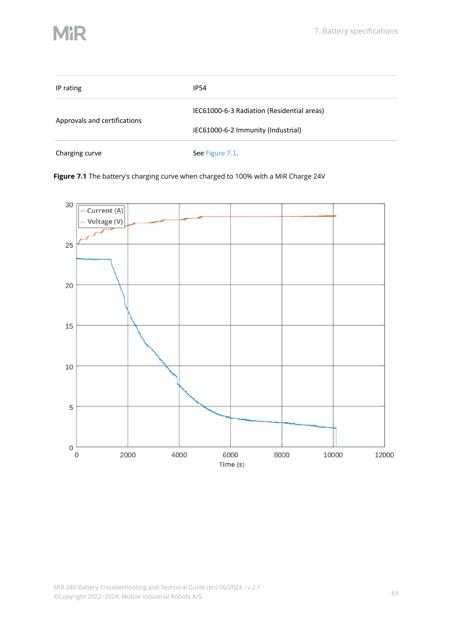


MiR 24V Battery Troubleshooting and Technical Guide, Page: 33


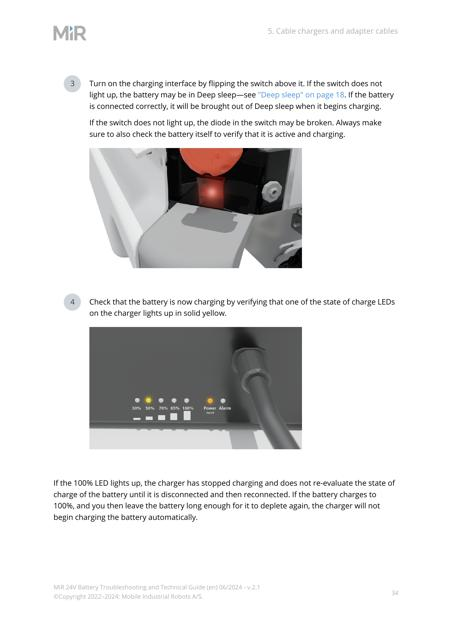



Battery-related error codes?
Battery-related error codes?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 63


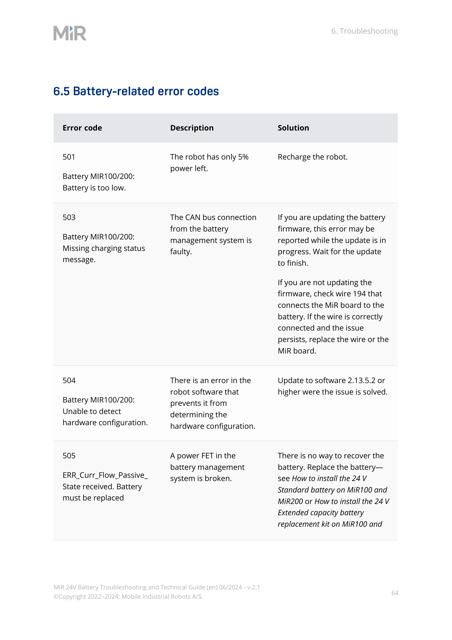


MiR 24V Battery Troubleshooting and Technical Guide, Page: 64


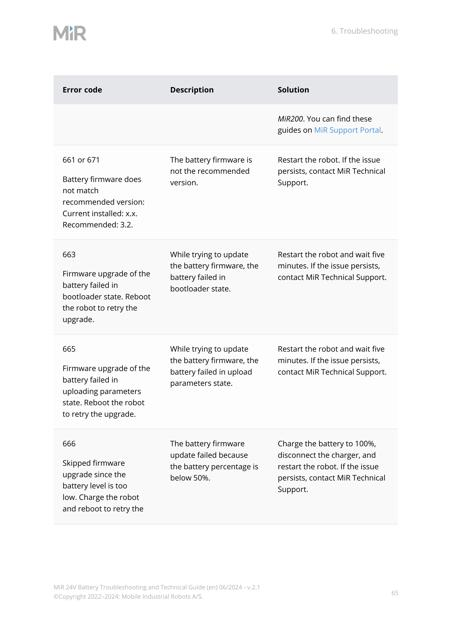


MiR 24V Battery Troubleshooting and Technical Guide, Page: 65


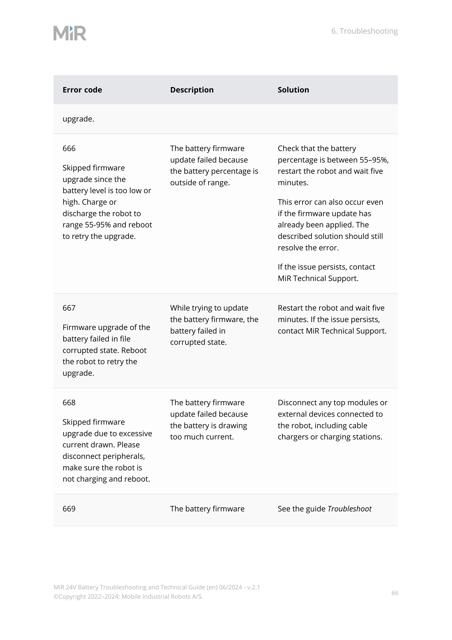



Host-cycling procedure?
Host-cycling procedure?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 62


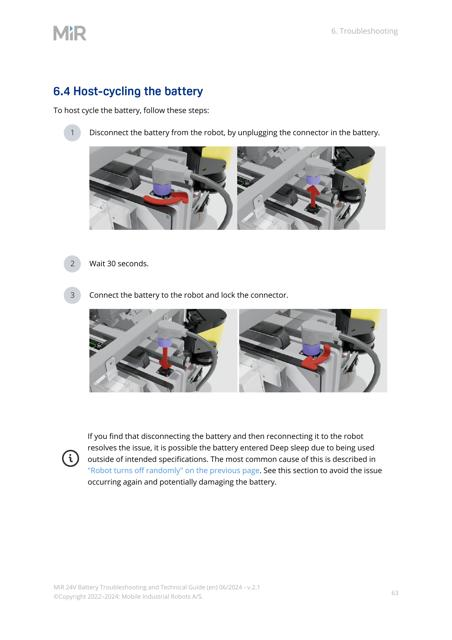


MiR 24V Battery Troubleshooting and Technical Guide, Page: 46


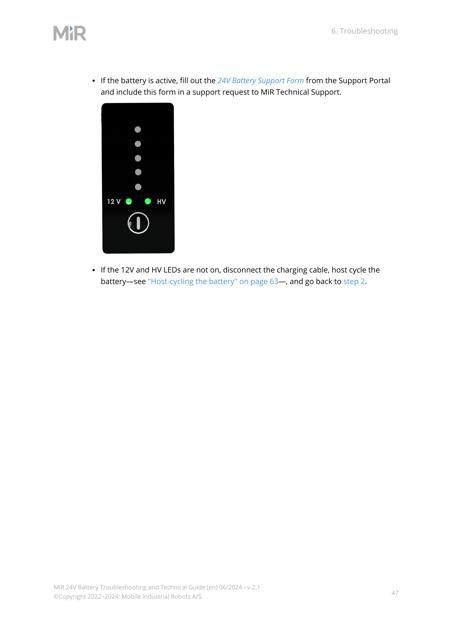


MiR 24V Battery Troubleshooting and Technical Guide, Page: 51


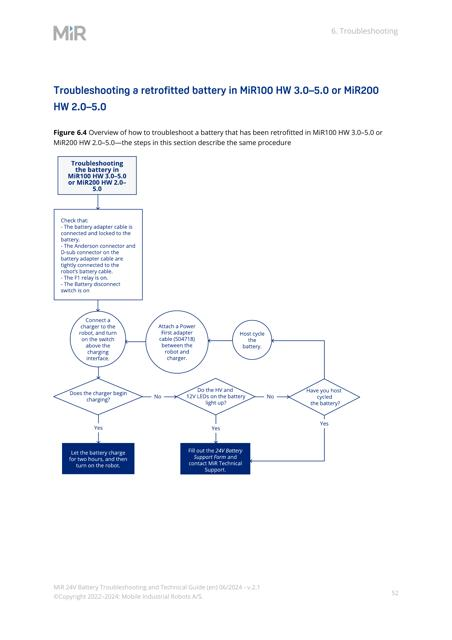



F1 relay function?
F1 relay function?:
MiR 24V Battery Troubleshooting and Technical Guide, Page: 15


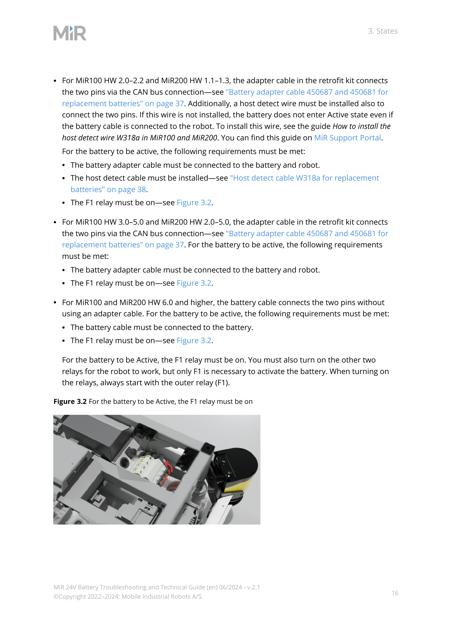


MiR 24V Battery Troubleshooting and Technical Guide, Page: 18


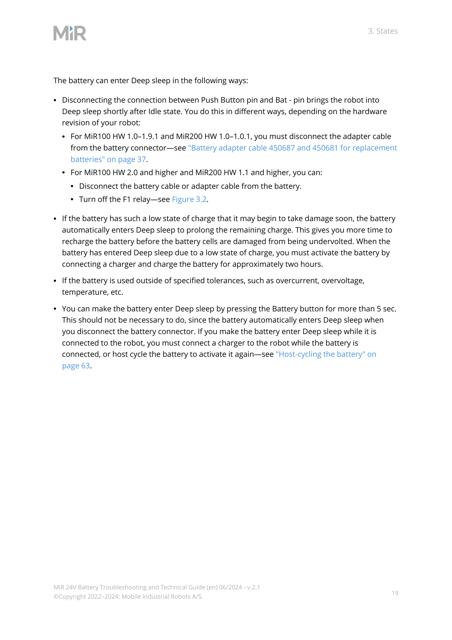


MiR 24V Battery Troubleshooting and Technical Guide, Page: 26


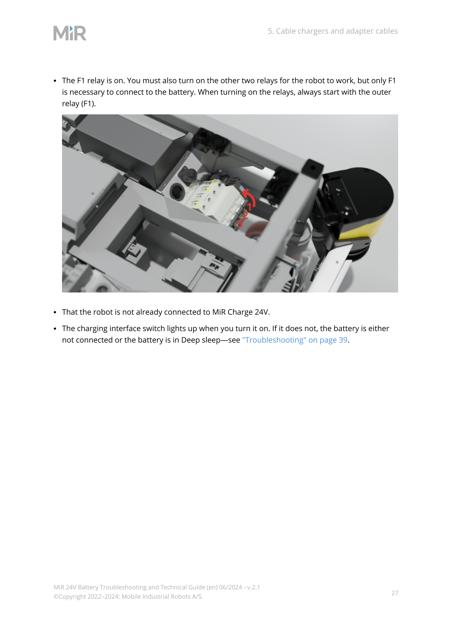

In [ ]:
for question in questions:
    print(question["question"])
    question["answer"] = retrieve(question["question"], show=True)
    print("")